In [169]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [170]:
# emiss_lim_list = 100.0 * np.array([1.0, 2.5, 5, 10, 15, 20, 25])
emiss_lim_list = 100.0 * np.array([5, 25])

In [171]:
result_dir = Path.cwd().joinpath('Results')
result_dir.is_dir()

True

In [172]:
inputs_dir = Path.cwd().parent.parent.joinpath('data','primal_6zoneandQC_baseloadfpp')
inputs_dir.is_dir()

True

In [173]:
baseline_results_dir = Path.cwd().parent.parent.joinpath('corrected_battery','primal_6zoneandQC_baseline','Results')
baseline_results_dir.is_dir()

False

In [174]:
baseline_inputs_dir = Path.cwd().parent.parent.parent.joinpath('data','primal_6zoneandQC_baseline')
baseline_inputs_dir.is_dir()

False

In [175]:
plots_dir = result_dir.joinpath('Plots')
Path.mkdir(plots_dir, exist_ok=True)

In [176]:
result_files_root = f"Primal_Capex_8500.0_EmissLevel_"

In [177]:
def get_resource_types(df):
    # For each row in df, look at the "Resource" entry
    # and remove the number after the last underscore
    # to find the tech type.
    # Add the column of tech types to the df.
    tech_types = []
    for row in df.itertuples():
        tech_type = '_'.join(row.Resource.split('_')[:-1])
        tech_types.append(tech_type)
    df['ResourceType'] = tech_types
    return df


In [178]:
def get_resource_names(df, resource_names):
    tech_names = []
    for row in df.itertuples(): 
        tech_name = resource_names[row.ResourceType]
        tech_names.append(tech_name)
    df['ResourceName'] = tech_names
    return df


In [179]:
def get_zone_names(df, zone_names):
    zone_names_list = []
    for row in df.itertuples():
        zone_name = zone_names[row.Zone]
        zone_names_list.append(zone_name)
    df['ZoneName'] = zone_names_list
    return df

In [180]:
def load_results(result_df, result_dir, result_files_root, emiss_lim_list, resource_names, zone_names, line_names):
    for emiss_lim in emiss_lim_list:

        print(f"Loading results for {emiss_lim} %")
        
        result_files = result_dir.joinpath(f"{result_files_root}{emiss_lim}")

        df_capacity = pd.read_csv(result_files.joinpath("capacity.csv"),thousands=',')
        # Set any values below 0.1 to 0
        df_capacity.loc[df_capacity.EndCap <= 0.1, "EndCap"] = 0.0
        # Drop total in last row
        df_capacity = df_capacity.drop(df_capacity.index[-1])
        # Get tech types and add to DataFrame
        df_capacity = get_resource_types(df_capacity)
        df_capacity = get_resource_names(df_capacity, resource_names)
        df_capacity = get_zone_names(df_capacity, zone_names)

        # Make a new DataFrame with only the EndCa[] values, indexed by Zone and ResourceName, indexed by Zone
        df_capacity_by_zone = df_capacity.pivot(index='ZoneName', columns='ResourceName', values='EndCap')    
        df_capacity_by_zone = df_capacity_by_zone.fillna(0.0)

        result_df[emiss_lim]['capacity'] = df_capacity
        result_df[emiss_lim]['capacity_by_zone'] = df_capacity_by_zone

        result_df[emiss_lim]['capacity'] = df_capacity
        result_df[emiss_lim]['capacity_by_zone'] = df_capacity_by_zone

        df_power = pd.read_csv(result_files.joinpath("power.csv"), thousands=',')
        # Drop last column
        df_power = df_power.drop(df_power.columns[-1], axis=1)
        # Drop the first and second rows with zone and AnnualSum
        df_power = df_power.drop(df_power.index[[0, 1]])
        # Set the index to be from 1 : length of df_power
        df_power.index = range(1, len(df_power) + 1)
        # # Change the Resource column name to Time
        # df_power = df_power.rename(columns={'Resource': 'Time'})
        # Remove the Resource column
        df_power = df_power.drop('Resource', axis=1)
        # Set any values below 0.1 to 0
        df_power[df_power <= 0.1] = 0.0

        # Make a new empty DataFrame which is indexed by the zone names and the same column names as df_capacity_by_zone
        df_power_by_zone = pd.DataFrame(index=zone_names.values(), columns=df_capacity_by_zone.columns)
        # For each column of df_power, find the zone number based splitting the column name and taking the last element
        # then find the zone name based on the zone number
        # then find the tech type based on splitting the column name and taking all but the last element
        # then find the tech name based on the tech type
        # then add the value of the column to the correct row and column of df_power_by_zone
        for col_name in df_power.columns:
            zone = col_name.split('_')[-1]
            zone_name = zone_names[float(zone)]
            tech_type = '_'.join(col_name.split('_')[:-1])
            tech_name = resource_names[tech_type]
            df_power_by_zone.loc[zone_name,tech_name] = df_power[col_name].sum()
        # Fill any NaN values with 0.0
        df_power_by_zone = df_power_by_zone.fillna(0.0)

        result_df[emiss_lim]['power'] = df_power
        result_df[emiss_lim]['power_by_zone'] = df_power_by_zone

        df_charge = pd.read_csv(result_files.joinpath("charge.csv"),thousands=',')
        # Drop last column
        df_charge = df_charge.drop(df_charge.columns[-1], axis=1)
        # Drop the first and second rows with zone and AnnualSum
        df_charge = df_charge.drop(df_charge.index[[0, 1]])
        # Set the index to be from 1 : length of df_power
        df_charge.index = range(1, len(df_charge) + 1)
        # Remove the Resource column
        df_charge = df_charge.drop('Resource', axis=1)
        # Set any values below 0.1 to 0
        df_charge[df_charge <= 0.1] = 0.0

        # Make a new empty DataFrame which is indexed by the zone names and the same column names as df_capacity_by_zone
        df_charge_by_zone = pd.DataFrame(index=zone_names.values(), columns=df_capacity_by_zone.columns)
        for col_name in df_charge.columns:
            zone = col_name.split('_')[-1]
            zone_name = zone_names[float(zone)]
            tech_type = '_'.join(col_name.split('_')[:-1])
            tech_name = resource_names[tech_type]
            df_charge_by_zone.loc[zone_name,tech_name] = df_charge[col_name].sum()
        # Fill any NaN values with 0.0
        df_charge_by_zone = df_charge_by_zone.fillna(0.0)

        result_df[emiss_lim]['charge'] = df_charge
        result_df[emiss_lim]['charge_by_zone'] = df_charge_by_zone

        df_flow = pd.read_csv(result_files.joinpath("flow.csv"), thousands=',')
        # Drop the first row
        df_flow = df_flow.drop(df_flow.index[0])
        # Drop the last column 
        df_flow = df_flow.drop(df_flow.columns[-1], axis=1)
        # Set the index to be from 1 : length of df_flow
        df_flow.index = range(1, len(df_flow) + 1)
        # Remove the Line column
        df_flow = df_flow.drop('Line', axis=1)
        # Rename the columns names using the line_names dictionary
        df_flow.rename(columns=line_names, inplace=True)

        result_df[emiss_lim]['flow'] = df_flow

        if result_files.joinpath("fusion","fusion_var.csv").is_file():
            df_fusion = pd.read_csv(result_files.joinpath("fusion","fusion_var.csv"))
            result_df[emiss_lim]['fusion'] = df_fusion
    return result_df

In [181]:
def isone_results(result_df, result_dir, result_files_root, emiss_lim_list):
    for emiss_lim in emiss_lim_list:
        result_files = result_dir.joinpath(f"{result_files_root}{emiss_lim}")
        # Divide the generations in df_power_by_zone by the capacities in df_capacity_by_zone to get the capacity factors
        df_power_by_zone = result_df[emiss_lim]['power_by_zone'].copy()

        # Get Fusion gross electric power
        # dfGen = result_df[emiss_lim]['dfGen']
        # if 'fusion' in result_df[emiss_lim]:
        #     df_fusion = result_df[emiss_lim]['fusion'] # Fusion outputs
        # fusion_gross_gen = [0.0] # Start with 0.0 for Quebec
        # counter = 0
        # fusion_count = 0
        # for index, row in dfGen.iterrows():
        #     counter += 1
        #     if row['FUSION'] == 1 and row['New_Build'] == 1:
        #         fusion_count += 1
        #         # Open /fusion
        #         df_fusion_timeseries = pd.read_csv(result_files.joinpath("fusion",f"fusion_time_{counter}.csv"))
        #         gross_elec_gen = df_fusion_timeseries['Gross Electric']
        #         # Set items <= 0.1 to 0.0
        #         gross_elec_gen[gross_elec_gen <= 0.1] = 0.0
        #         fusion_gross_gen.append(gross_elec_gen.sum())
        # if fusion_count > 0:
        #     # These are in zone-order
        #     df_power_by_zone.loc[:, 'Fusion'] = fusion_gross_gen

        df_cap_factor = 100.0 / 8760.0 * df_power_by_zone.div(result_df[emiss_lim]['capacity_by_zone'] * 190 / 263) 
        # Fill any NaN values with 0.0
        df_cap_factor = df_cap_factor.fillna(0.0)

        result_df[emiss_lim]['cap_factor'] = df_cap_factor

        QC_DEMAND = 217357818.5 # MWhe

        df_isone_power_by_zone = result_df[emiss_lim]['power_by_zone'].copy()
        QC_gen = result_df[emiss_lim]['power_by_zone'].loc['QC','Reservoir Hydro']
        # QC_trans = result_df[emiss_lim]['flow'].loc[:, 'QC->MA'].values # Negative = exports, Positive = imports
        # QC_exports = np.sum(-QC_trans[QC_trans < 0.0])
        # QC_imports = np.sum(QC_trans[QC_trans >= 0.0])
        QC_trans = result_df[emiss_lim]['flow'].loc[:, 'QC->MA'].values # Negative = exports, Positive = imports
        QC_imports = np.sum(-QC_trans[QC_trans < 0.0])
        QC_exports = np.sum(QC_trans[QC_trans >= 0.0])

        # Reduce other gen by the amount imported to QC
        # Assume each generator does so equally
        gen_by_zone = df_isone_power_by_zone.sum(axis=1)
        gen_except_QC = gen_by_zone.drop('QC')
        temp = np.sum(QC_imports) / np.sum(gen_except_QC)
        df_isone_power_by_zone *= (1.0 - temp)

        df_isone_power_by_zone.loc['QC','Reservoir Hydro'] = QC_exports
        # if fusion_count > 0:
        #     df_isone_power_by_zone.loc[:, 'Fusion'] = [x * (1.0 - temp) for x in fusion_gross_gen]

        df_isone_cap_factor = 100.0 / 8760.0 * df_isone_power_by_zone.div(result_df[emiss_lim]['capacity_by_zone'] * 190 / 263)
        # Fill any NaN values with 0.0
        df_isone_cap_factor = df_isone_cap_factor.fillna(0.0)

        result_df[emiss_lim]['isone_power_by_zone'] = df_isone_power_by_zone
        result_df[emiss_lim]['isone_cap_factor'] = df_isone_cap_factor
        
    return result_df

In [182]:
def load_inputs(result_df, inputs_dir, emiss_lim_list):
    for emiss_lim in emiss_lim_list:
        dfGen = pd.read_csv(inputs_dir.joinpath(f"Generators_data.csv"))
        result_df[emiss_lim]['dfGen'] = dfGen
        dfFusion = pd.read_csv(inputs_dir.joinpath(f"Fusion_data.csv"))
        result_df[emiss_lim]['dfFusion'] = dfFusion
    return result_df

In [183]:
resource_names = {
    'res_hydro': 'Reservoir Hydro',
    'natural_gas': 'Natural Gas CombCycle',
    'natural_gas_ccs': 'Nat Gas CombCycle + CCS',
    'solar_pv': 'Solar PV',
    'battery': '4hr Li-ion',
    'offshore_wind': 'Offshore Wind',
    'onshore_wind': 'Onshore Wind',
    'ror_hydro': 'Run of River Hydro',
    'pumped_hydro': 'Pumped Hydro',
    'nuclear': 'Fission',
    'fusion': 'Fusion'
}

resource_colors = {
    'res_hydro': 'xkcd:sky blue',
    'natural_gas': '#7F7F7F',
    'natural_gas_ccs': '#BFBFBF',
    'solar_pv': '#F5C242',
    'battery': 'xkcd:dark grey',
    'offshore_wind': '#5E813F',
    'onshore_wind': '#B1D095',
    'ror_hydro': '#4F71BE',
    'pumped_hydro': 'xkcd:light violet',
    'nuclear': 'xkcd:silver',
    'fusion': '#68349A'
}

resource_colors_by_name = {
    resource_names[key]: color for key, color in resource_colors.items()
}

zone_names = {
    1.0: 'QC',
    2.0: 'ME',
    3.0: 'NH',
    4.0: 'VT',
    5.0: 'MA',
    6.0: 'RI',
    7.0: 'CT'    
}


line_names = {
    '1': 'QC->MA',
    '2': 'QC->VT',
    '3': 'ME->NH',
    '4': 'NH->VT',
    '5': 'NH->MA',
    '6': 'VT->MA',
    '7': 'MA->RI',
    '8': 'MA->CT',
    '9': 'RI->CT',
}

In [184]:
result_df = {}
for emiss_lim in emiss_lim_list:
    result_df[emiss_lim] = {}

baseline_result_df = {}
for emiss_lim in emiss_lim_list:
    baseline_result_df[emiss_lim] = {}

In [185]:
result_df = load_results(result_df, result_dir, result_files_root, emiss_lim_list, resource_names, zone_names, line_names)
result_df = load_inputs(result_df, inputs_dir, emiss_lim_list)

# baseline_result_df = load_results(baseline_result_df, baseline_results_dir, "Primal_Baseline_EmissLevel_", emiss_lim_list, resource_names, zone_names, line_names)
# baseline_result_df = load_inputs(baseline_result_df, baseline_inputs_dir, emiss_lim_list)

Loading results for 500.0 %
Loading results for 2500.0 %


# Calculate capacity factors and ISO-NE only generation
This includes calculating the Fusion capacity factor based on the gross electric output, not net electric output

In [186]:
result_df = isone_results(result_df, result_dir, result_files_root, emiss_lim_list)
# baseline_result_df = isone_results(baseline_result_df, Path.cwd().parent.joinpath('primal_6zoneandQC_baseline','Results'), "Primal_Baseline_EmissLevel_", emiss_lim_list)

# Write summaries to CSV

In [187]:
summaries = {
    'power_by_zone': 'summ_power_by_zone.csv',
    'capacity_by_zone': 'summ_capacity_by_zone.csv',
    'cap_factor': 'summ_cap_factor.csv',
    'isone_power_by_zone': 'summ_isone_power_by_zone.csv',
    'isone_cap_factor': 'summ_isone_cap_factor.csv',
}
for emiss_lim in emiss_lim_list:
    for summary, file_name in summaries.items():
        summ_dir = result_dir.joinpath("summaries", summary)
        Path.mkdir(summ_dir, exist_ok=True, parents=True)
        result_df[emiss_lim][summary].to_csv(summ_dir.joinpath(f"EmissLevel_{emiss_lim}_{file_name}"), index=True)

In [188]:
def json_2_results(json_file):
    result_df = {}
    with open(json_file) as f:
        data = json.load(f)
    for key, value in data.items():
        result_df[float(key)] = pd.DataFrame(value)
    return result_df

In [189]:
def results_2_json_dict(result_df):
    # For each entry in result_df, resursively check if it's a DataFrame.
    # If it is, use pd.to_json() to convert it to a string
    # If it's not, return the entry as is.
    # Return a dictionary of the results.
    result_dict = {}
    for emiss_lim, value in result_df.items():
        result_dict[emiss_lim] = {}
        for key2, value2 in value.items():
            if isinstance(value2, pd.DataFrame):
                result_dict[emiss_lim][key2] = value2.to_json()
            else:
                result_dict[emiss_lim][key2] = value2
    return result_dict

In [190]:
# ## Write result_df to a json file
# result_dict = results_2_json_dict(result_df)
# with open(result_dir.joinpath('result_df.json'), 'w') as fp:
#     json.dump(result_dict, fp, indent=4) 

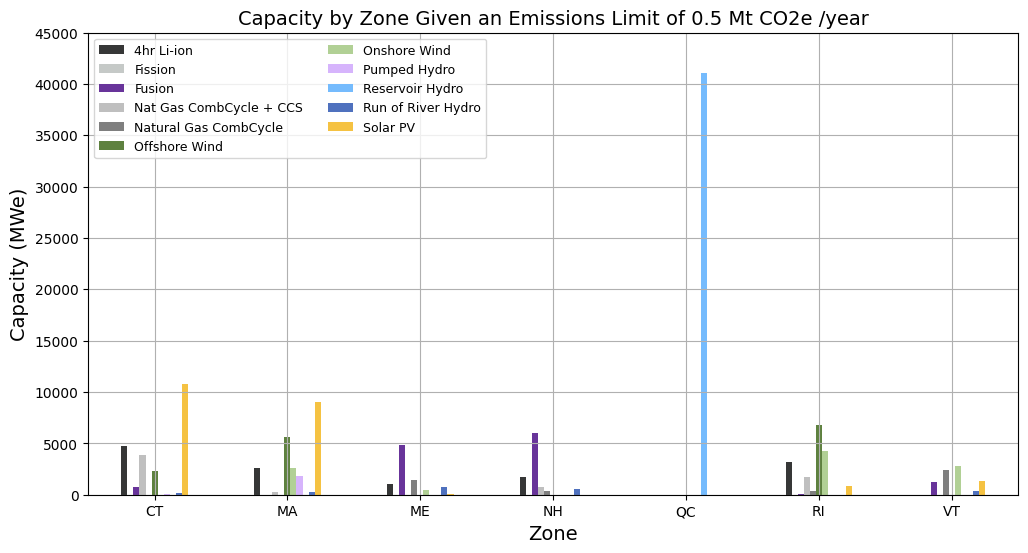

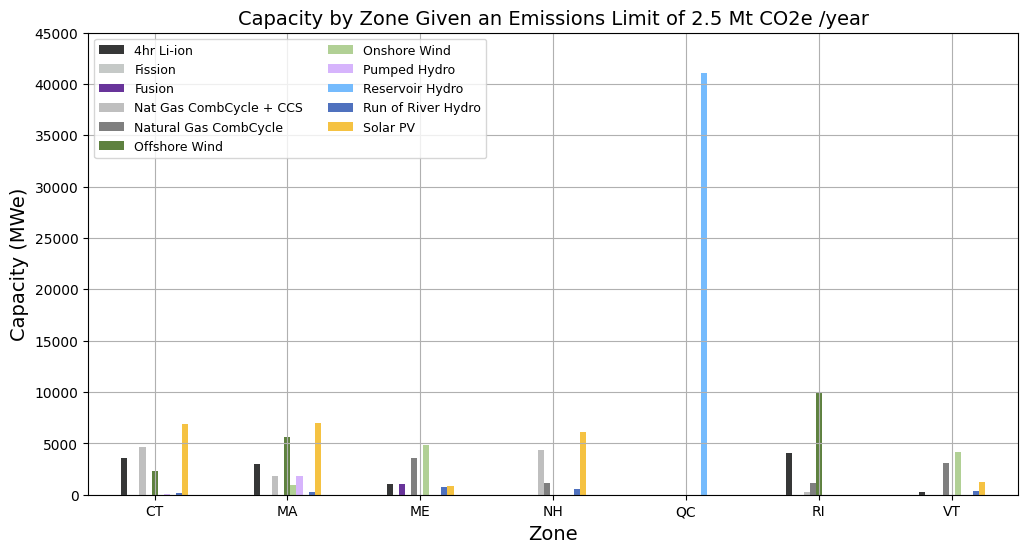

In [191]:
temp_plot_dir = plots_dir.joinpath("capacity_by_zone")
Path.mkdir(temp_plot_dir, exist_ok=True, parents=True)

for emiss_lim in emiss_lim_list:
    df_capacity_by_zone =  result_df[emiss_lim]['capacity_by_zone']

    fig, ax = plt.subplots(figsize=(12, 6))
    df_capacity_by_zone.plot.bar(ax=ax, rot=0, color=resource_colors_by_name)
    ax.set_ylabel('Capacity (MWe)', fontsize=14)
    ax.set_xlabel('Zone', fontsize=14)
    ax.set_title(f"Capacity by Zone Given an Emissions Limit of {emiss_lim/1000} Mt CO2e /year", fontsize=14)
    ax.grid(True)
    ax.set_ylim([0, 45e3])
    ax.legend(ncols=2, fontsize=9)
    fig.savefig(temp_plot_dir.joinpath(f"Capacity_by_Zone_co2_{emiss_lim}.png"), dpi=300)

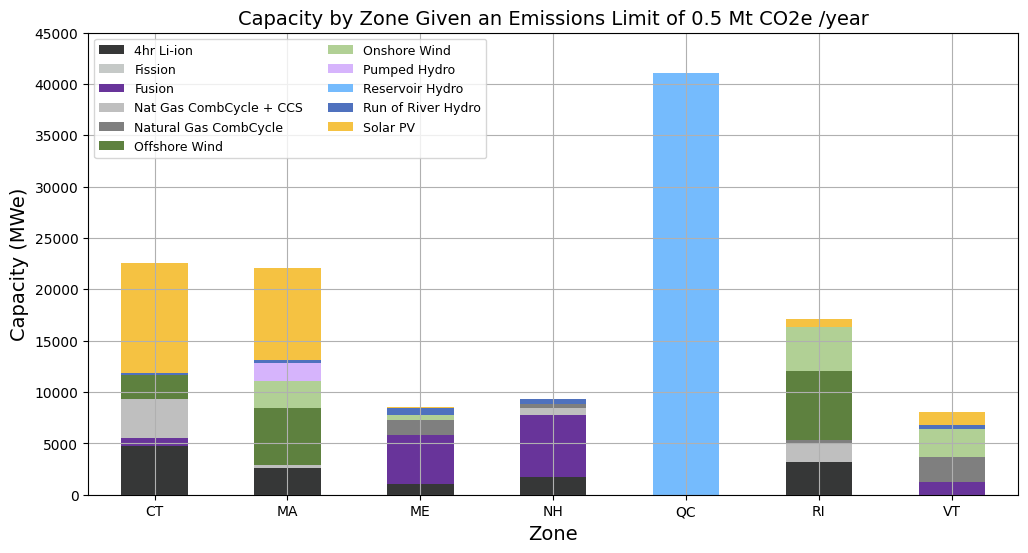

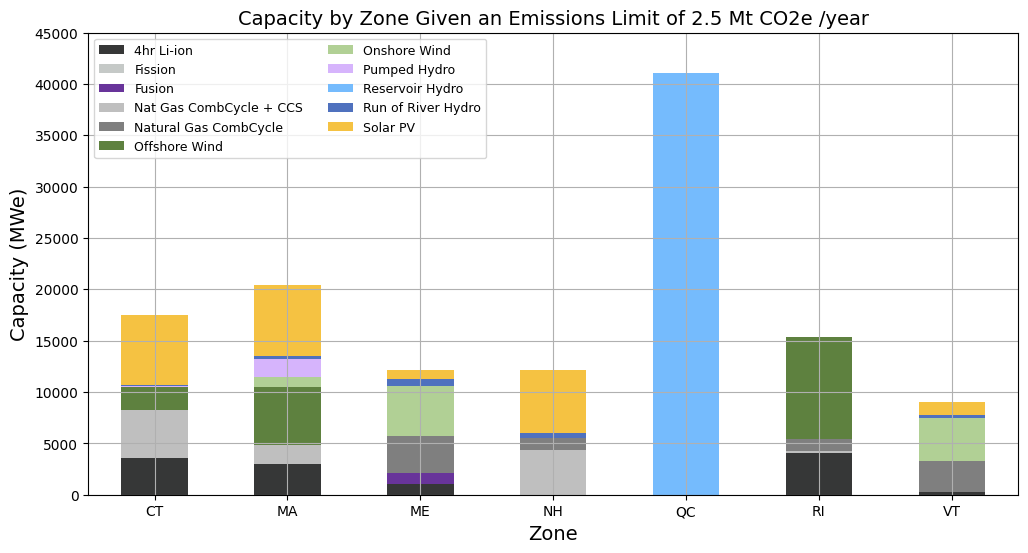

In [192]:
temp_plot_dir = plots_dir.joinpath("stacked_capacity_by_zone")
Path.mkdir(temp_plot_dir, exist_ok=True)

for emiss_lim in emiss_lim_list:
    df_capacity_by_zone =  result_df[emiss_lim]['capacity_by_zone']

    fig, ax = plt.subplots(figsize=(12, 6))
    df_capacity_by_zone.plot.bar(ax=ax, stacked=True, rot=0, color=resource_colors_by_name)
    ax.set_ylabel('Capacity (MWe)', fontsize=14)
    ax.set_xlabel('Zone', fontsize=14)
    ax.set_title(f"Capacity by Zone Given an Emissions Limit of {emiss_lim/1000} Mt CO2e /year", fontsize=14)
    ax.grid(True)
    ax.legend(ncols=2, fontsize=9)
    ax.set_ylim([0, 45e3])
    fig.savefig(temp_plot_dir.joinpath(f"Stacked_Capacity_by_Zone_co2_{emiss_lim}.png"), dpi=300)

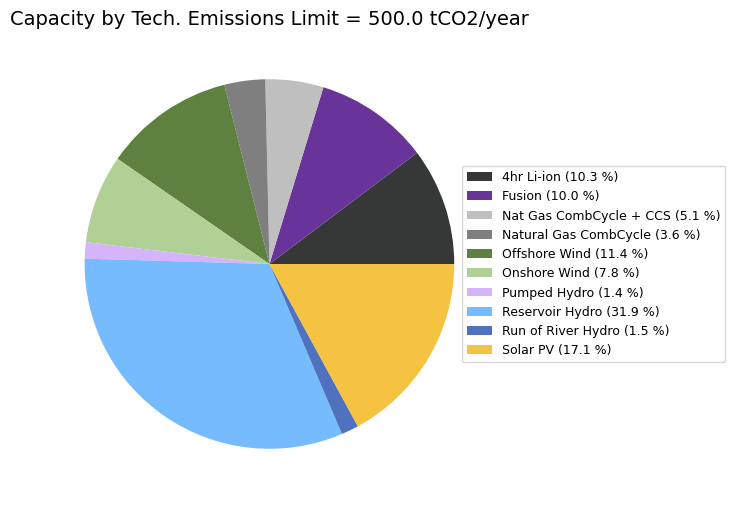

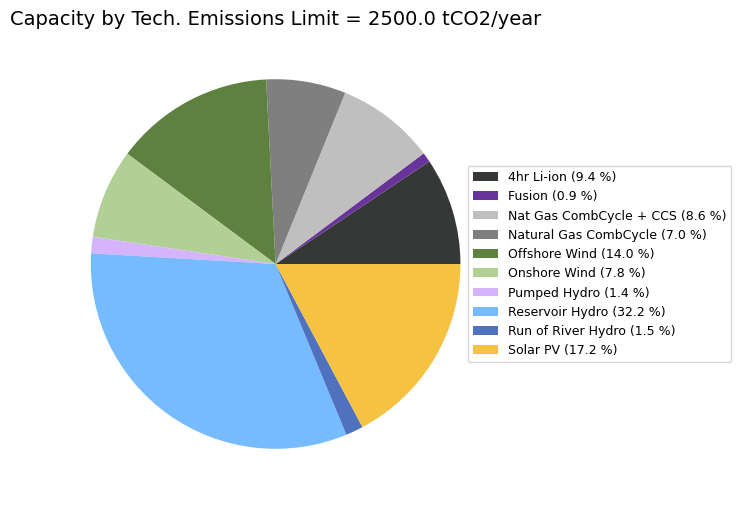

In [193]:
temp_plot_dir = plots_dir.joinpath("capacity_by_tech")
Path.mkdir(temp_plot_dir, exist_ok=True)

for emiss_lim in emiss_lim_list:
    df_capacity_by_zone =  result_df[emiss_lim]['capacity_by_zone']

    cap_sum = df_capacity_by_zone.sum()
    cap_sum = cap_sum.loc[cap_sum>0]
    cap_sum_colors = [resource_colors_by_name[tech] for tech in cap_sum.index]
    cap_percent = cap_sum / cap_sum.sum() * 100.0
    
    fig, ax = plt.subplots(figsize=(12, 6))
    cap_sum.plot.pie(ax=ax, colors=cap_sum_colors, labeldistance=None)
    labels = [f"{tech} ({cap_percent[tech]:.1f} %)" for tech, cap in cap_sum.items()]
    ax.legend(labels, loc='right', bbox_to_anchor=(1.5, 0.5), fontsize=9)
    ax.set_title(f"Capacity by Tech. Emissions Limit = {emiss_lim} tCO2/year", fontsize=14)
    fig.savefig(temp_plot_dir.joinpath(f"Capacity_by_Tech_co2_{emiss_lim}.png"), dpi=300)

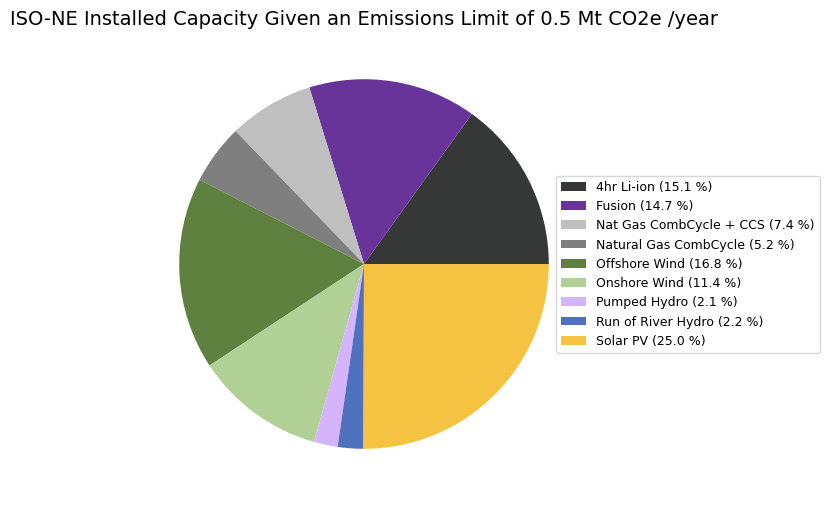

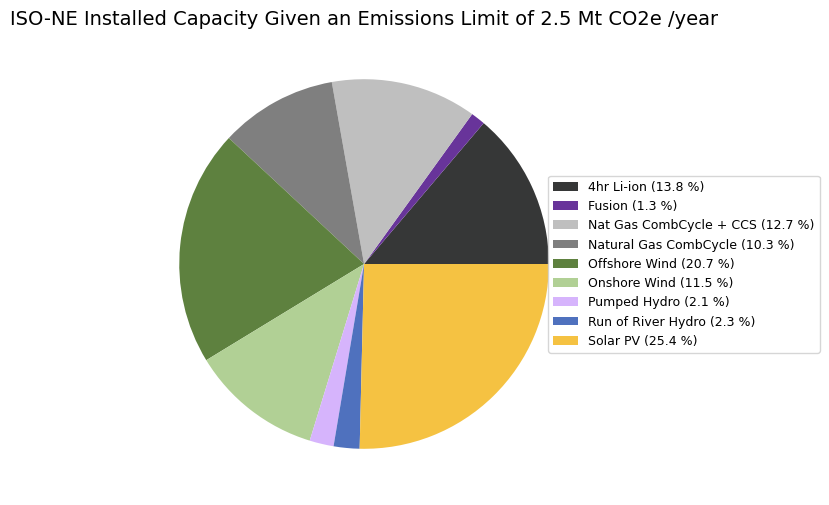

In [194]:
temp_plot_dir = plots_dir.joinpath("isone_capacity_by_tech")
Path.mkdir(temp_plot_dir, exist_ok=True)

for emiss_lim in emiss_lim_list:
    all_cap =  result_df[emiss_lim]['capacity_by_zone']
    # Drop QC row
    df_capacity_by_zone = all_cap.drop("QC")

    cap_sum = df_capacity_by_zone.sum()
    cap_sum = cap_sum.loc[cap_sum>0]
    cap_sum_colors = [resource_colors_by_name[tech] for tech in cap_sum.index]
    cap_percent = cap_sum / cap_sum.sum() * 100.0
    
    fig, ax = plt.subplots(figsize=(12, 6))
    cap_sum.plot.pie(ax=ax, colors=cap_sum_colors, labeldistance=None)
    labels = [f"{tech} ({cap_percent[tech]:.1f} %)" for tech, cap in cap_sum.items()]
    ax.legend(labels, loc='right', bbox_to_anchor=(1.5, 0.5), fontsize=9)
    ax.set_title(f"ISO-NE Installed Capacity Given an Emissions Limit of {emiss_lim/1000} Mt CO2e /year", fontsize=14)
    fig.savefig(temp_plot_dir.joinpath(f"ISONE_Capacity_by_Tech_co2_{emiss_lim}.png"), dpi=300)

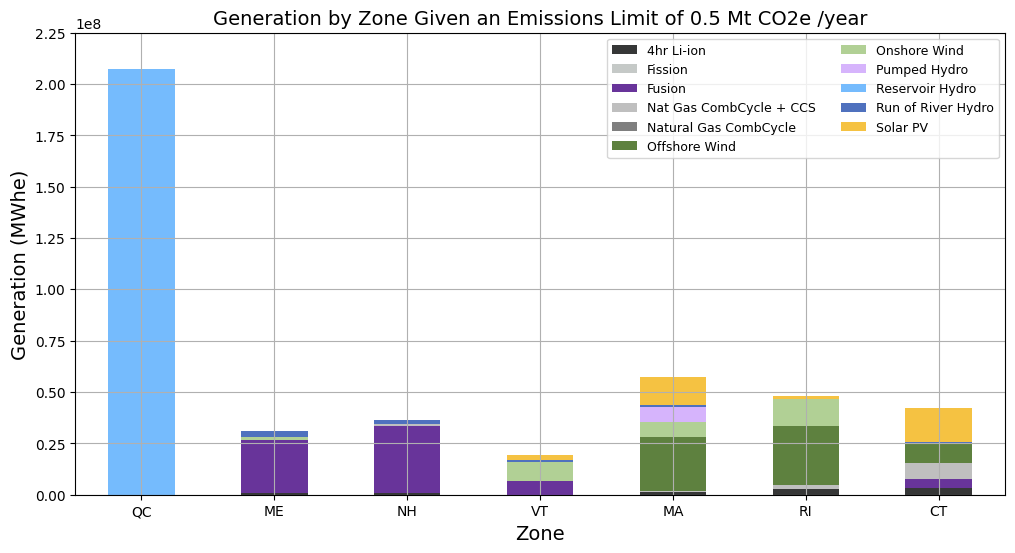

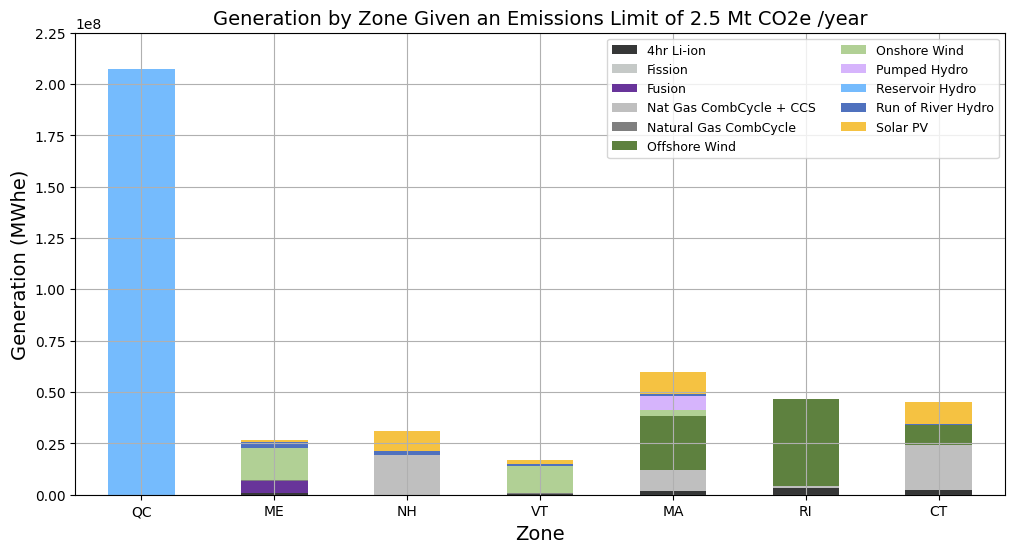

In [195]:
temp_plot_dir = plots_dir.joinpath("gen_by_zone")
Path.mkdir(temp_plot_dir, exist_ok=True)

for emiss_lim in emiss_lim_list:
    df_capacity_by_zone =  result_df[emiss_lim]['power_by_zone']

    fig, ax = plt.subplots(figsize=(12, 6))
    df_capacity_by_zone.plot.bar(ax=ax, stacked=True, rot=0, color=resource_colors_by_name)
    ax.set_ylabel('Generation (MWhe)', fontsize=14)
    ax.set_xlabel('Zone', fontsize=14)
    ax.set_title(f"Generation by Zone Given an Emissions Limit of {emiss_lim/1000} Mt CO2e /year", fontsize=14)
    ax.grid(True)
    ax.legend(ncols=2, fontsize=9)
    ax.set_ylim([0, 2.25e8])
    fig.savefig(temp_plot_dir.joinpath(f"Gen_by_Zone_co2_{emiss_lim}.png"), dpi=300)

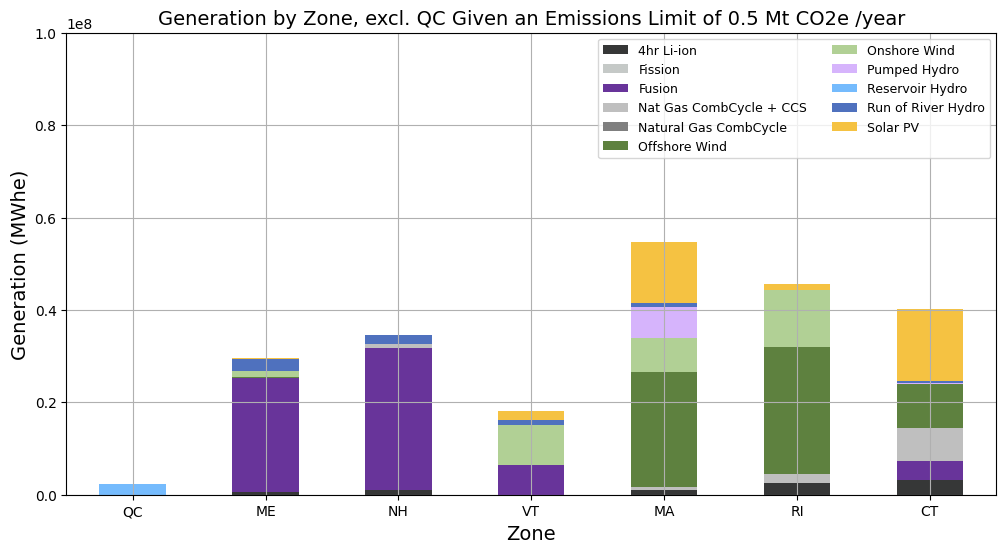

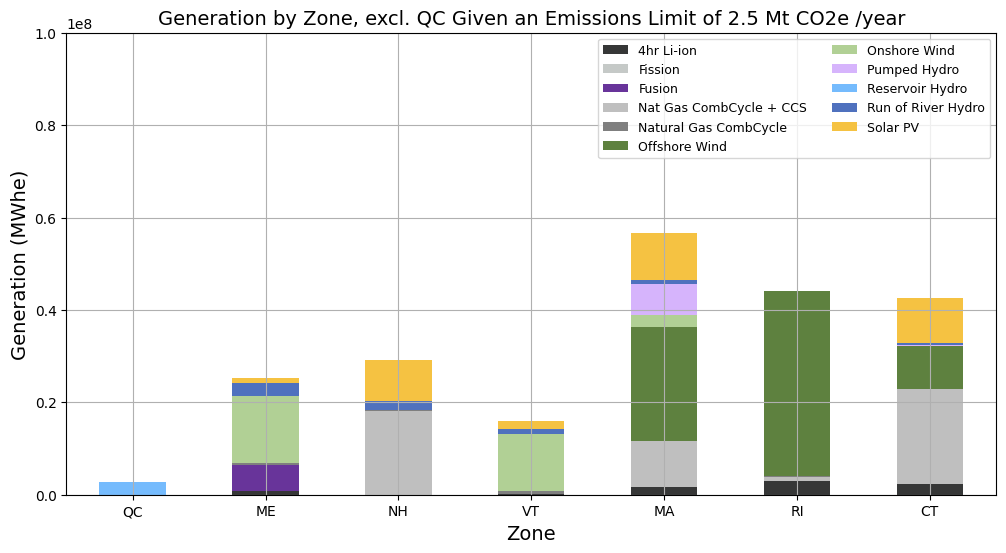

In [196]:
temp_plot_dir = plots_dir.joinpath("isone_gen_by_zone")
Path.mkdir(temp_plot_dir, exist_ok=True)

for emiss_lim in emiss_lim_list:
    df_capacity_by_zone =  result_df[emiss_lim]['isone_power_by_zone']

    fig, ax = plt.subplots(figsize=(12, 6))
    df_capacity_by_zone.plot.bar(ax=ax, stacked=True, rot=0, color=resource_colors_by_name)
    ax.set_ylabel('Generation (MWhe)', fontsize=14)
    ax.set_xlabel('Zone', fontsize=14)
    ax.set_title(f"Generation by Zone, excl. QC Given an Emissions Limit of {emiss_lim/1000} Mt CO2e /year", fontsize=14)
    ax.grid(True)
    ax.legend(ncols=2, fontsize=9)
    ax.set_ylim([0, 1e8])
    fig.savefig(temp_plot_dir.joinpath(f"ISONE_Gen_by_Zone_co2_{emiss_lim}.png"), dpi=300)

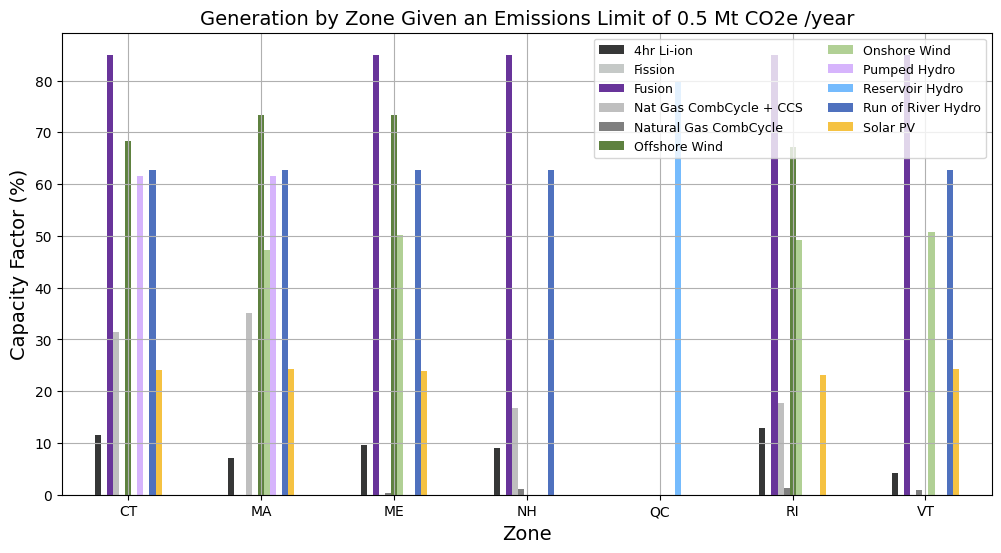

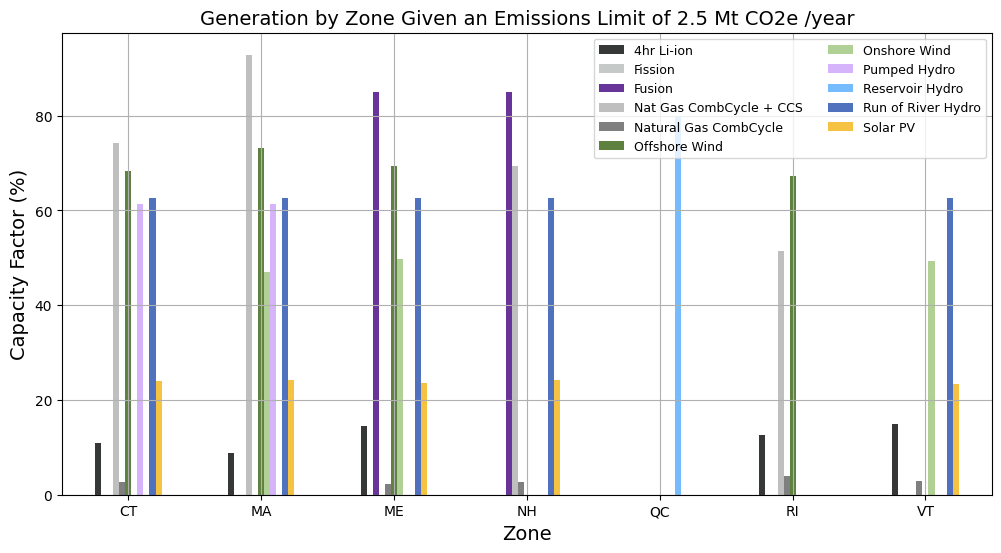

In [197]:
temp_plot_dir = plots_dir.joinpath("cap_factor_by_zone")
Path.mkdir(temp_plot_dir, exist_ok=True)

for emiss_lim in emiss_lim_list:
    df_cap_factor = result_df[emiss_lim]['cap_factor']

    fig, ax = plt.subplots(figsize=(12, 6))
    df_cap_factor.plot.bar(ax=ax, rot=0, color=resource_colors_by_name)
    ax.set_ylabel('Capacity Factor (%)', fontsize=14)
    ax.set_xlabel('Zone', fontsize=14)
    ax.set_title(f"Generation by Zone Given an Emissions Limit of {emiss_lim/1000} Mt CO2e /year", fontsize=14)
    ax.grid(True)
    ax.legend(ncols=2, fontsize=9)
    fig.savefig(temp_plot_dir.joinpath(f"Cap_Factor_by_Zone_co2_{emiss_lim}.png"), dpi=300)

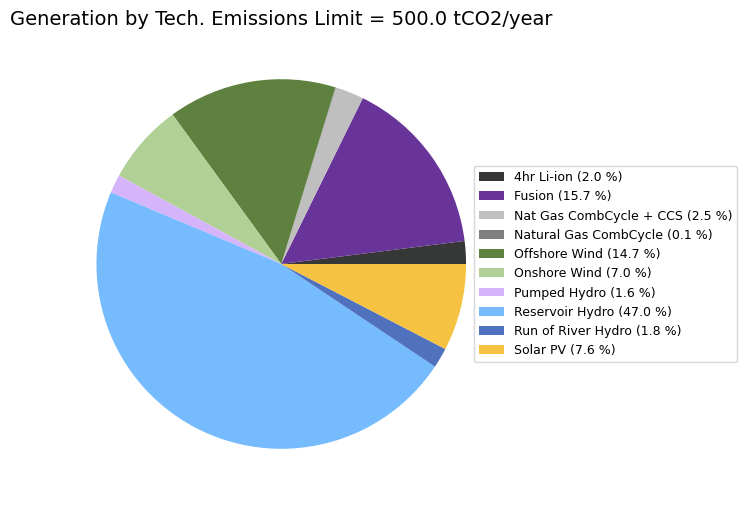

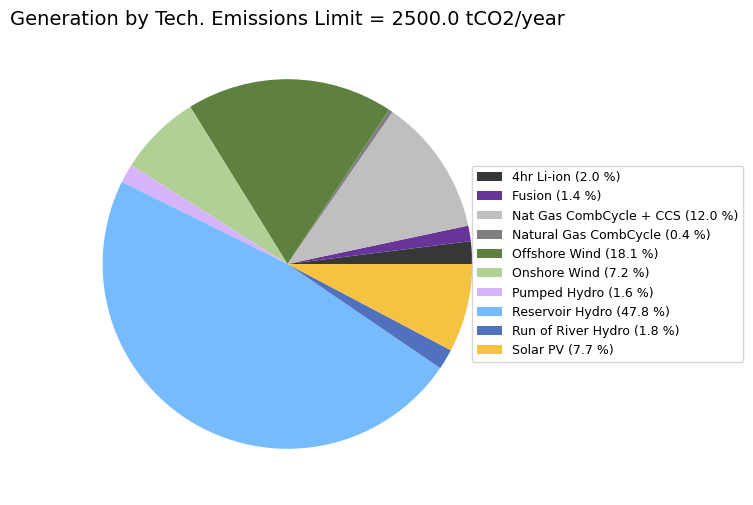

In [198]:
temp_plot_dir = plots_dir.joinpath("gen_by_tech")
Path.mkdir(temp_plot_dir, exist_ok=True)

for emiss_lim in emiss_lim_list:
    df_gen_by_zone = result_df[emiss_lim]['power_by_zone']

    gen_sum = df_gen_by_zone.sum()
    gen_sum = gen_sum.loc[gen_sum>0]
    gen_sum_colors = [resource_colors_by_name[tech] for tech in gen_sum.index]
    gen_percent = gen_sum / gen_sum.sum() * 100.0
    
    fig, ax = plt.subplots(figsize=(12, 6))
    gen_sum.plot.pie(ax=ax, colors=gen_sum_colors, labeldistance=None)
    labels = [f"{tech} ({gen_percent[tech]:.1f} %)" for tech, cap in gen_sum.items()]
    ax.legend(labels, loc='right', bbox_to_anchor=(1.5, 0.5), fontsize=9)
    ax.set_title(f"Generation by Tech. Emissions Limit = {emiss_lim} tCO2/year", fontsize=14)
    fig.savefig(temp_plot_dir.joinpath(f"Gen_by_Tech_co2_{emiss_lim}.png"), dpi=300)

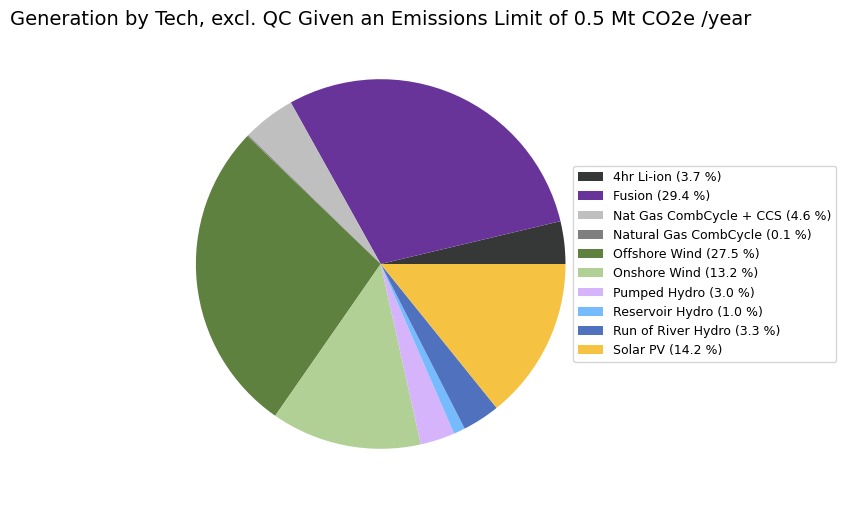

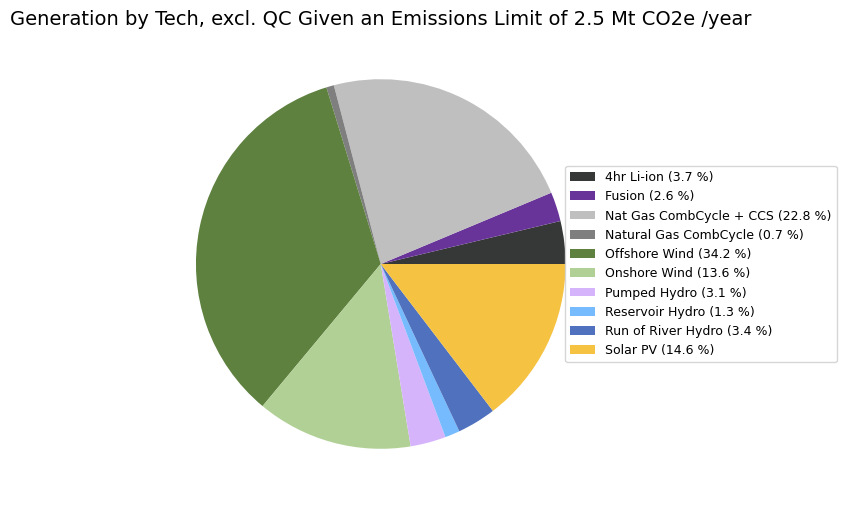

In [199]:
temp_plot_dir = plots_dir.joinpath("isone_gen_by_tech")
Path.mkdir(temp_plot_dir, exist_ok=True)

for emiss_lim in emiss_lim_list:
    df_gen_by_zone = result_df[emiss_lim]['isone_power_by_zone']

    gen_sum = df_gen_by_zone.sum()
    gen_sum = gen_sum.loc[gen_sum>0]
    gen_sum_colors = [resource_colors_by_name[tech] for tech in gen_sum.index]
    gen_percent = gen_sum / gen_sum.sum() * 100.0
    
    fig, ax = plt.subplots(figsize=(12, 6))
    gen_sum.plot.pie(ax=ax, colors=gen_sum_colors, labeldistance=None)
    labels = [f"{tech} ({gen_percent[tech]:.1f} %)" for tech, cap in gen_sum.items()]
    ax.legend(labels, loc='right', bbox_to_anchor=(1.5, 0.5), fontsize=9)
    ax.set_title(f"Generation by Tech, excl. QC Given an Emissions Limit of {emiss_lim/1000} Mt CO2e /year", fontsize=14)
    fig.savefig(temp_plot_dir.joinpath(f"ISONE_Gen_by_Tech_co2_{emiss_lim}.png"), dpi=300)

# Plot sorted QC -> ME transmission

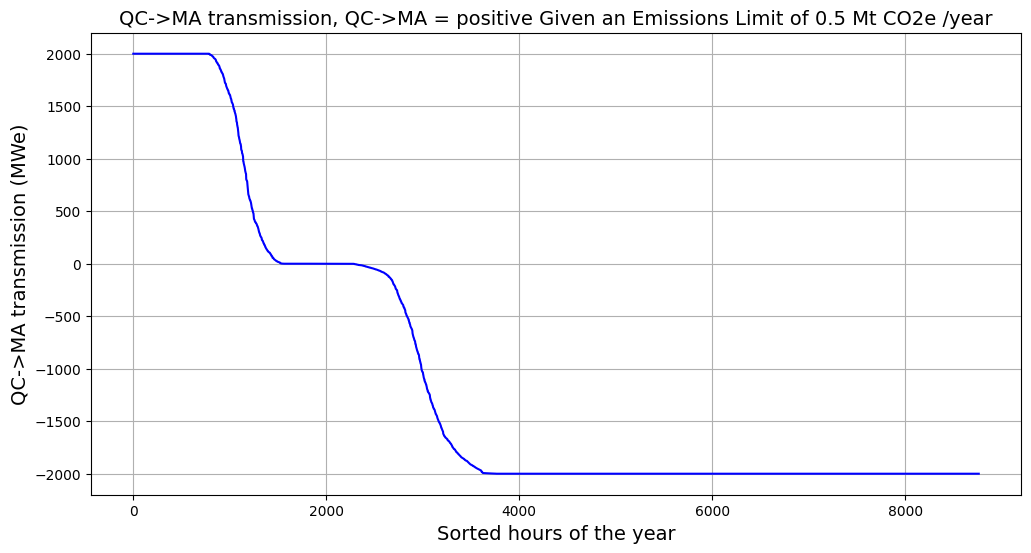

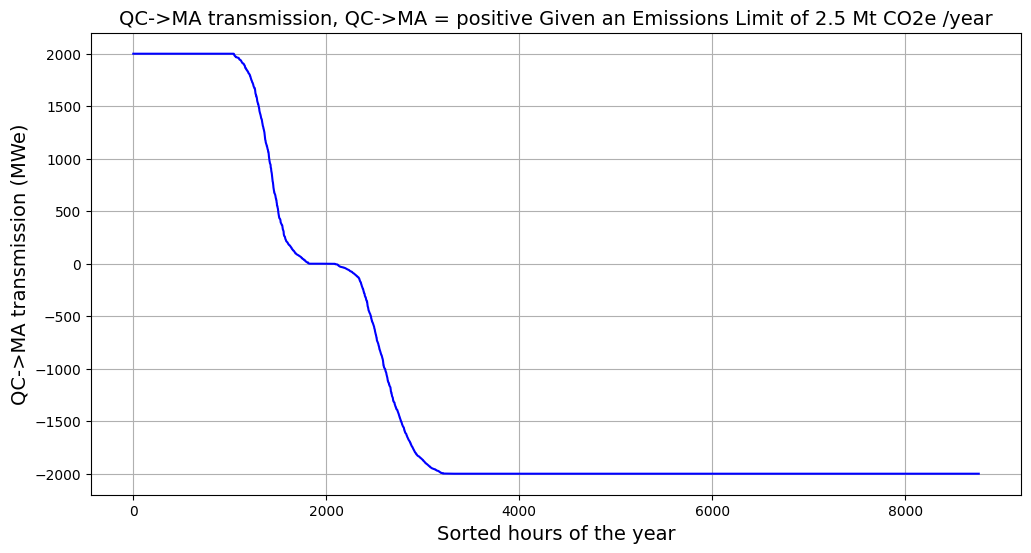

In [200]:
temp_plot_dir = plots_dir.joinpath("QC_2_MA_trans")
Path.mkdir(temp_plot_dir, exist_ok=True)

for emiss_lim in emiss_lim_list:
    df_flow = result_df[emiss_lim]['flow']
    sorted_qc_2_me = df_flow.loc[:,'QC->MA'].sort_values(ascending=False)
    # Reset index to be from 1 : length of df_flow
    sorted_qc_2_me.index = range(1, len(sorted_qc_2_me) + 1)
    fig, ax = plt.subplots(figsize=(12, 6))
    sorted_qc_2_me.plot(ax=ax, color='blue')
    ax.set_xlabel('Sorted hours of the year', fontsize=14)
    ax.set_ylabel('QC->MA transmission (MWe)', fontsize=14)
    ax.set_title(f"QC->MA transmission, QC->MA = positive Given an Emissions Limit of {emiss_lim/1000} Mt CO2e /year", fontsize=14)
    ax.grid(True)
    fig.savefig(temp_plot_dir.joinpath(f"QC_2_MA_trans_{emiss_lim}.png"), dpi=300)

In [201]:
# temp_plot_dir = plots_dir.joinpath("change_in_capacity_by_tech")
# Path.mkdir(temp_plot_dir, exist_ok=True)

# for emiss_lim in emiss_lim_list:
#     df_capacity_by_zone =  result_df[emiss_lim]['capacity_by_zone']
#     baseline_df_capacity_by_zone =  baseline_result_df[emiss_lim]['capacity_by_zone']
#     temp = df_capacity_by_zone - baseline_df_capacity_by_zone
#     temp = temp.sum()

#     fig, ax = plt.subplots(figsize=(12, 6))
#     # plt.bar(range(len(temp)), temp, color=[resource_colors_by_name[x] for x in temp.index])
#     temp.plot.bar(ax=ax, rot=45)
#     # ax.set_xticklabels(temp.index, rotation=45)
#     ax.set_ylabel('Capacity (MWe)', fontsize=14)
#     ax.set_xlabel('Zone', fontsize=14)
#     ax.set_title(f"Change in Capacity by Tech, Emissions Limit = {emiss_lim} tCO2/year", fontsize=12)
#     ax.grid(True)
#     # ax.legend(ncols=2, fontsize=9)
#     # ax.set_ylim([-40e3, 15e3])
#     fig.savefig(temp_plot_dir.joinpath(f"Change_in_Capacity_by_tech_co2_{emiss_lim}.png"), dpi=300)

In [202]:
# temp_plot_dir = plots_dir.joinpath("change_in_stacked_capacity_by_zone")
# Path.mkdir(temp_plot_dir, exist_ok=True)

# for emiss_lim in emiss_lim_list:
#     df_capacity_by_zone =  result_df[emiss_lim]['capacity_by_zone']
#     baseline_df_capacity_by_zone =  baseline_result_df[emiss_lim]['capacity_by_zone']
#     temp = df_capacity_by_zone - baseline_df_capacity_by_zone

#     fig, ax = plt.subplots(figsize=(12, 6))
#     temp.plot.bar(ax=ax, stacked=True, rot=0, color=resource_colors_by_name)
#     ax.set_ylabel('Capacity (MWe)', fontsize=14)
#     ax.set_xlabel('Zone', fontsize=14)
#     ax.set_title(f"Change in Capacity by Zone Given an Emissions Limit of {emiss_lim/1000} Mt CO2e /year", fontsize=14)
#     ax.grid(True)
#     ax.legend(ncols=2, fontsize=9)
#     ax.set_ylim([-40e3, 15e3])
#     fig.savefig(temp_plot_dir.joinpath(f"Stacked_Change_in_Capacity_by_Zone_co2_{emiss_lim}.png"), dpi=300)

# Winter dispatch examples

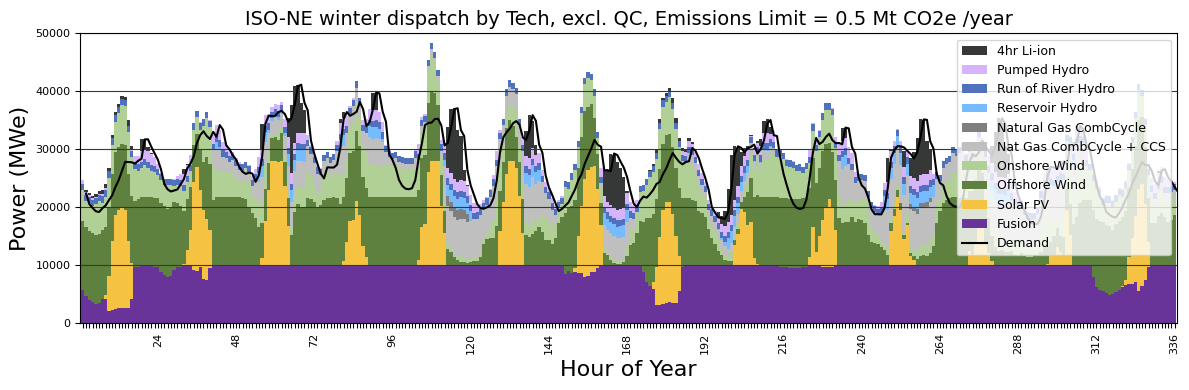

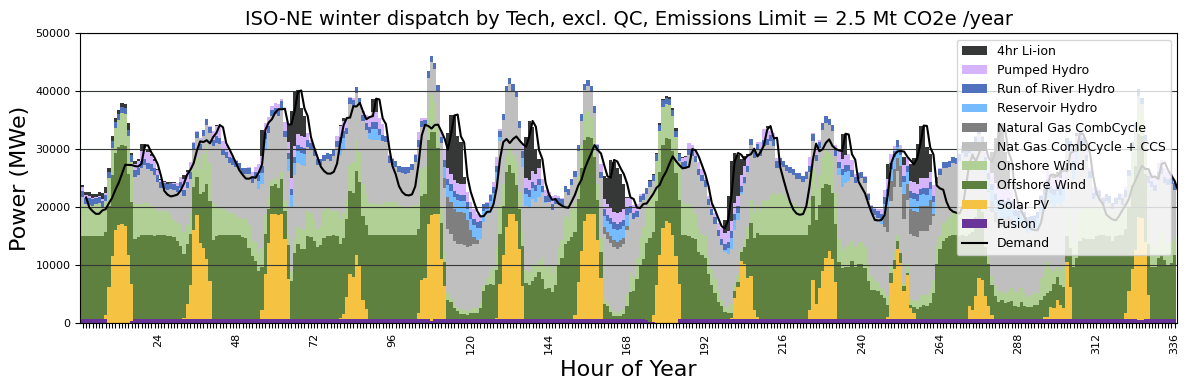

In [203]:
temp_plot_dir = plots_dir.joinpath("isone_winter_dispatch_by_tech")
Path.mkdir(temp_plot_dir, exist_ok=True, parents=True)

min_time = 1
max_time = 24 * 14

for emiss_lim in emiss_lim_list:
    fig, ax = plt.subplots(figsize=(12, 4))
    temp_pow = result_df[emiss_lim]['power'].loc[min_time:max_time, :]
    pow_2_plot = pd.DataFrame(index=np.arange(min_time,max_time+1), columns=resource_colors.keys())
    for resource in resource_colors.keys():
        data = np.zeros_like(np.arange(min_time,max_time+1))
        for col_name in temp_pow.columns:
            zone_number = col_name.split('_')[-1]
            tech_type = '_'.join(col_name.split('_')[:-1])
            if tech_type == resource:
                data = data + temp_pow[col_name]
        pow_2_plot[resource] = data

    QC_trans = result_df[emiss_lim]['flow'].loc[min_time:max_time, 'QC->MA'].values
    QC_trans[QC_trans<0] = 0
    pow_2_plot['res_hydro'] = QC_trans

    # col_order = [
    #     'Fusion',
    #     'Solar PV',
    #     'Offshore Wind',
    #     'Onshore Wind',
    #     'Nat Gas CombCycle + CCS',
    #     'Natural Gas CombCycle',
    #     'Reservoir Hydro'
    #     'Run of River Hydro'
    #     'Pumped Hydro',
    #     '4hr Li-ion',
    # ]
    col_order = [
        'fusion',
        'solar_pv',
        'offshore_wind',
        'onshore_wind',
        'natural_gas_ccs',
        'natural_gas',
        'res_hydro',
        'ror_hydro',
        'pumped_hydro',
        'battery',
    ]
    # Reorder columns
    pow_2_plot = pow_2_plot[col_order]

    pow_2_plot.plot.bar(ax=ax, stacked=True, width=1.0, fontsize=8, color=resource_colors)
    ax.set_xticklabels([t if not (i+1)%24 else "" for i,t in enumerate(ax.get_xticklabels())])
    ax.set_ylim([0, 5e4])

    temp_charge = result_df[emiss_lim]['charge'].loc[min_time:max_time, :]
    demand = ax.plot(
        np.arange(min_time, max_time+1),
        pow_2_plot.sum(axis=1) - temp_charge.sum(axis=1),
        color='xkcd:black',
        label='Demand'
    )

    resource_names['Demand'] = 'Demand'
    
    handles, labels = ax.get_legend_handles_labels()
    labels = [resource_names[x] for x in labels]

    # Reverse legend order:
    handles = handles[::-1]
    labels = labels[::-1]

    # handles.append(demand)
    # labels.append('Demand')
    ax.legend(handles, labels, loc='upper right', fontsize=9)

    ax.grid(True, axis='y', color='xkcd:dark grey')
    ax.set_xlabel('Hour of Year', fontsize = 16)
    ax.set_ylabel('Power (MWe)', fontsize = 16)
    ax.set_title(f"ISO-NE winter dispatch by Tech, excl. QC, Emissions Limit = {emiss_lim/1000} Mt CO2e /year", fontsize=14)
    fig.tight_layout()

    fig.savefig(temp_plot_dir.joinpath(f"ISONE_Winter_Dispatch_By_Tech_{emiss_lim}.png"), dpi=300)


# Summer dispatch examples

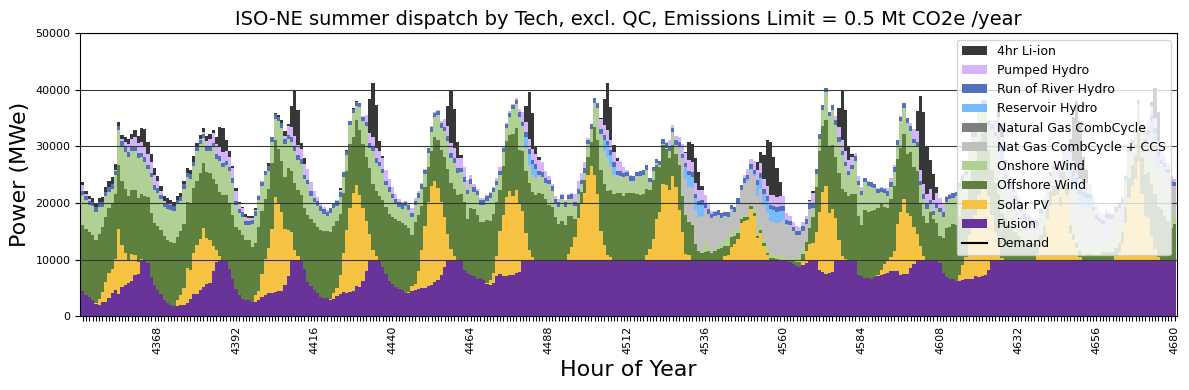

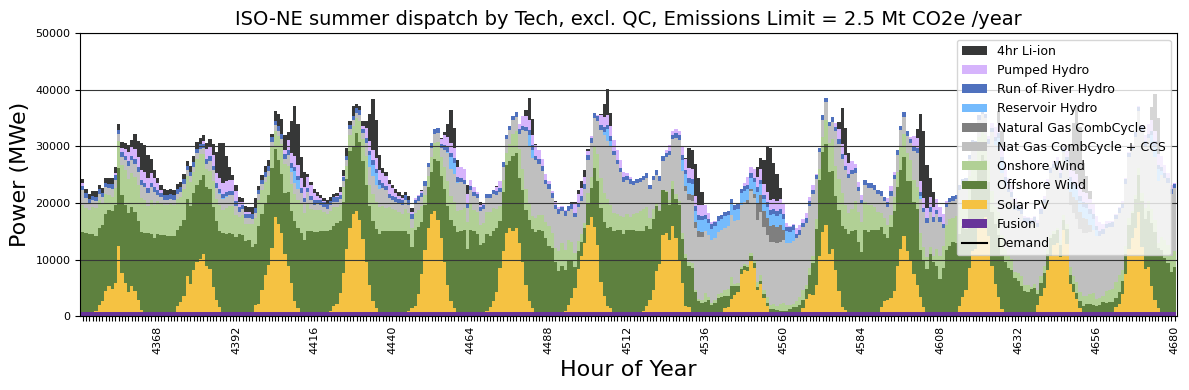

In [204]:
temp_plot_dir = plots_dir.joinpath("isone_summer_dispatch_by_tech")
Path.mkdir(temp_plot_dir, exist_ok=True, parents=True)

min_time = 181 * 24 + 1 # Midnight July 1st
max_time = min_time + 24 * 14 - 1

for emiss_lim in emiss_lim_list:
    fig, ax = plt.subplots(figsize=(12, 4))
    temp_pow = result_df[emiss_lim]['power'].loc[min_time:max_time, :]
    pow_2_plot = pd.DataFrame(index=np.arange(min_time,max_time+1), columns=resource_colors.keys())
    for resource in resource_colors.keys():
        data = np.zeros_like(np.arange(min_time,max_time+1))
        for col_name in temp_pow.columns:
            zone_number = col_name.split('_')[-1]
            tech_type = '_'.join(col_name.split('_')[:-1])
            if tech_type == resource:
                data = data + temp_pow[col_name]
        pow_2_plot[resource] = data

    QC_trans = result_df[emiss_lim]['flow'].loc[min_time:max_time, 'QC->MA'].values
    QC_trans[QC_trans<0] = 0
    pow_2_plot['res_hydro'] = QC_trans

    col_order = [
        'fusion',
        'solar_pv',
        'offshore_wind',
        'onshore_wind',
        'natural_gas_ccs',
        'natural_gas',
        'res_hydro',
        'ror_hydro',
        'pumped_hydro',
        'battery',
    ]
    # Reorder columns
    pow_2_plot = pow_2_plot[col_order]

    pow_2_plot.plot.bar(ax=ax, stacked=True, width=1.0, fontsize=8, color=resource_colors)
    ax.set_xticklabels([t if not (i+1)%24 else "" for i,t in enumerate(ax.get_xticklabels())])
    ax.set_ylim([0, 5e4])

    temp_charge = result_df[emiss_lim]['charge'].loc[min_time:max_time, :]
    demand = ax.plot(
        np.arange(min_time, max_time+1),
        pow_2_plot.sum(axis=1) - temp_charge.sum(axis=1),
        color='xkcd:black',
        label='Demand'
    )

    resource_names['Demand'] = 'Demand'
    
    handles, labels = ax.get_legend_handles_labels()
    labels = [resource_names[x] for x in labels]

    # Reverse legend order:
    handles = handles[::-1]
    labels = labels[::-1]

    # handles.append(demand)
    # labels.append('Demand')
    ax.legend(handles, labels, loc='upper right', fontsize=9)

    ax.grid(True, axis='y', color='xkcd:dark grey')
    ax.set_xlabel('Hour of Year', fontsize = 16)
    ax.set_ylabel('Power (MWe)', fontsize = 16)
    ax.set_title(f"ISO-NE summer dispatch by Tech, excl. QC, Emissions Limit = {emiss_lim/1000} Mt CO2e /year", fontsize=14)
    fig.tight_layout()

    fig.savefig(temp_plot_dir.joinpath(f"ISONE_Summer_Dispatch_By_Tech_{emiss_lim}.png"), dpi=300)
